# Predictions

## Imports

In [1]:
# load custom scripts
import config
from utils import *


# import the necessary packages
from albumentations.pytorch import ToTensorV2
from skimage import io
from torchmetrics import ConfusionMatrix
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import torch
import torchmetrics

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Plot function

In [3]:
classes = {0: 'no label',
           1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
          }

In [4]:
def prepare_plot(image, gtLabel, gtMask, predLabel):

    # plot the original image, its mask, and the predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    im1 = ax[0].imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    ax[0].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=30, marker='.', c='r')

    im2 = ax[1].imshow(gtLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20b', 10),
                       vmin=0, vmax=9)
    ax[1].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=30, marker='.', c='r')

    im3 = ax[2].imshow(predLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20b', 10),
                       vmin=0, vmax=9)
    ax[2].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=30, marker='.', c='r')


    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Labels")
    ax[2].set_title("Predicted Labels")

    # add colour bar
    fig.subplots_adjust(right=0.85)
    cbar = fig.colorbar(im3, ticks=list(classes.keys()), fraction=0.04)
    cbar.ax.set_yticklabels(list(classes.values()))

    # set the layout of the figure and display it
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()

## Testing loop

In [5]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        # load the labels from disk
        filename = imagePath.split(os.path.sep)[-1].replace("JPG","png")
        groundTruthPath = os.path.join(config.LABEL_DATASET_PATH, filename)
        gtLabel = io.imread(groundTruthPath)
        # load the mask from disk
        gtMask = io.imread(groundTruthPath.replace('labels', 'masks_9x9'))
        
        # apply transformation
        transformed = test_transform(image=image, mask=gtLabel, mask2=gtMask)
        image = transformed["image"]
        gtLabel = transformed["mask"]
        gtMask = transformed["mask2"]

        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to(config.DEVICE)

        # create mask tensor
        asarray = lambda x: torch.tensor(np.array(x), dtype=torch.long)
        gtLabel = asarray(np.expand_dims(gtLabel, 0))
        gtMask = asarray(np.expand_dims(gtMask, 0))

        # prediction
        predLabel = model(image).squeeze()
        predLabel = torch.argmax(predLabel, dim=0)
        predLabel = predLabel.cpu()
        
        # prepare a plot for visualization
        #prepare_plot(image, gtLabel.squeeze(), gtMask.squeeze(), predLabel)
    
    return gtLabel.squeeze(), gtMask.squeeze(), predLabel


In [6]:
test_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))],
    additional_targets={'mask2': 'mask'}
)

## Make predictions

In [7]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)
confmat = ConfusionMatrix(num_classes=10)

In [8]:
# initialize variables
accTestGT = 0
accTestAGT = 0
countTestGT = 0
countTestAGT = 0
cf_matrixGT = np.zeros((10,10)) 
cf_matrixAGT = np.zeros((10,10)) 

In [9]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=854)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load("/data/jantina/CoralNet/dataset/output/unet2.pth").to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
    gtLabel, gtMask, predLabel = make_predictions(unet, path)
                
    if torch.sum(gtMask)!=0: # GT and AGT
        # update the accuracy count
        countTestGT = countTestGT + 1
        countTestAGT = countTestAGT + 1
        # extract the GT label positions in the prediction
        pixel_predGT = torch.mul(gtMask, predLabel)
        # extract the GT label positions in the target
        pixel_targGT = torch.mul(gtMask, gtLabel)
        # metrics on current element
        accTestGT += acc(pixel_predGT, pixel_targGT)
        # confusion matrix
        cf_matrixGT += np.array(confmat(pixel_predGT, pixel_targGT))

        # extract the AGT label positions in the prediction
        pixel_predAGT = predLabel-pixel_predGT
        # extract the AGT label positions in the target
        pixel_targAGT = gtLabel-pixel_targGT
        # metrics on current element
        accTestAGT += acc(pixel_predAGT, pixel_targAGT)  
        # confusion matrix
        cf_matrixAGT += np.array(confmat(pixel_predAGT, pixel_targAGT))

    else: # only AGT
        # update the accuracy count
        countTestAGT = countTestAGT + 1
        # metrics on current element
        accTestAGT += acc(predLabel, gtLabel)
        # confusion matrix
        cf_matrixAGT += np.array(confmat(predLabel, gtLabel))

[INFO] loading up test image paths...
[INFO] load up model...


In [10]:
print("[INFO] The GT accuracy of the test set is: ", accTestGT/countTestGT)
print("[INFO] The AGT accuracy of the test set is: ", accTestAGT/countTestAGT)

[INFO] The GT accuracy of the test set is:  tensor(0.5256)
[INFO] The AGT accuracy of the test set is:  tensor(0.5530)


## GT Confusion Matrix

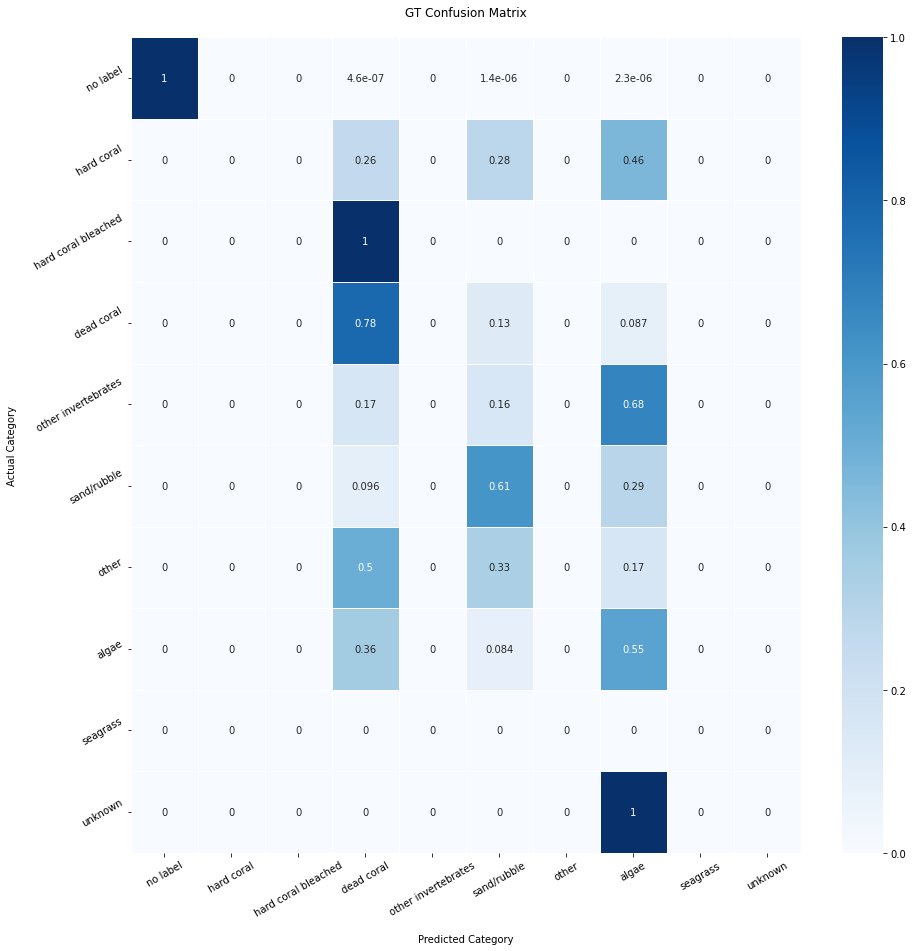

In [11]:
norm = np.copy(cf_matrixGT)

for i in range(len(cf_matrixGT)):
    if cf_matrixGT.sum(axis=1)[:, np.newaxis][i] != 0:
        norm[i,:] = cf_matrixGT[i,:] / cf_matrixGT.sum(axis=1)[:, np.newaxis][i]
        
# confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(norm, annot=True, cmap='Blues', linewidths=.5, ax=ax)

ax.set_title('GT Confusion Matrix\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category\n')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30)
ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30)

plt.show()

## AGT Confusion Matrix

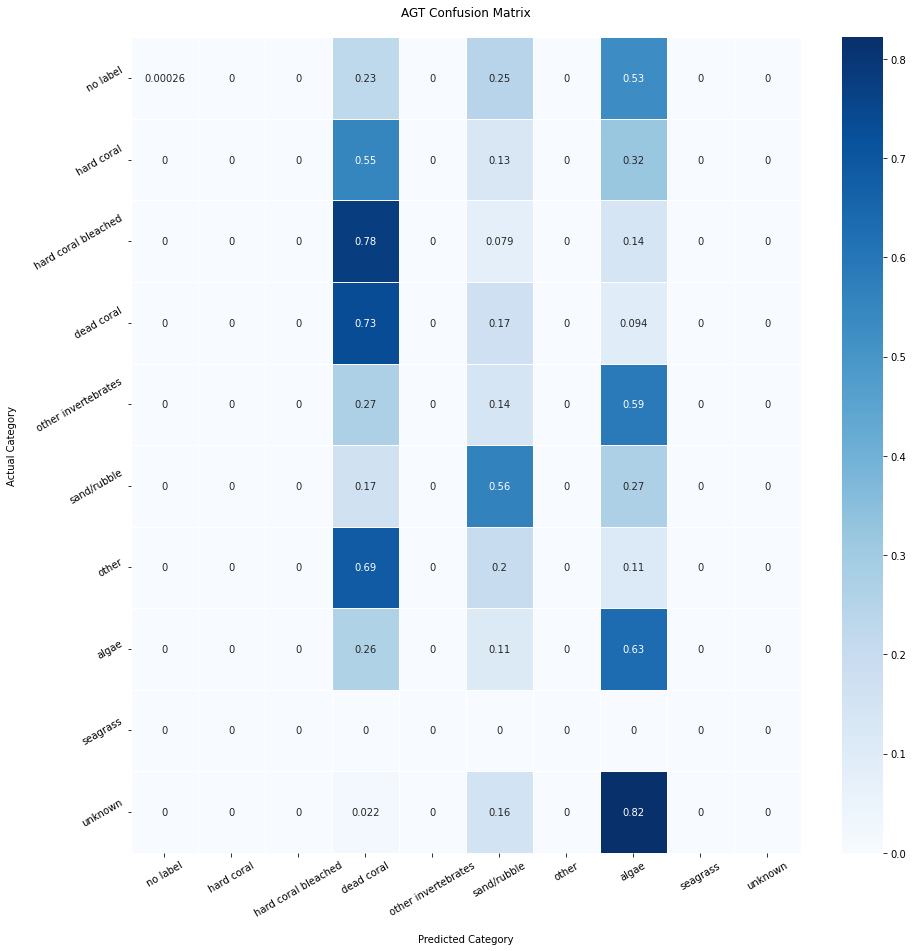

In [12]:
norm = np.copy(cf_matrixAGT)

for i in range(len(cf_matrixAGT)):
    if cf_matrixAGT.sum(axis=1)[:, np.newaxis][i] != 0:
        norm[i,:] = cf_matrixAGT[i,:] / cf_matrixAGT.sum(axis=1)[:, np.newaxis][i]
        
# confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(norm, annot=True, cmap='Blues', linewidths=.5, ax=ax)

ax.set_title('AGT Confusion Matrix\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category\n')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30)
ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30)

plt.show()